# Diffusion equation

Solve
$$
\partial_t c = D \partial_x^2 c  - k (c-c_o)
$$
on the interval $x \in [-\pi, \pi]$ with Neumann boundary conditions $\partial_x c |_{x=-\pi} = 0 = \partial_x c |_{x=\pi}$, and the initial condition $c(x,0) = c_i(x)$. The exact solution for this problem would be
$$
c_e(x,t) = c_o + \sum_{n \in \mathbb{Z}} c_n(0) e^{-(Dn^2 + k)t} \cos nx
$$

In [39]:
# necessary packages
from dolfinx import mesh
from mpi4py import MPI
from dolfinx import fem
from dolfinx.fem import FunctionSpace
import numpy as np
import dolfinx as dfx
import ufl as ufl
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
import pyvista as pv
import matplotlib.pyplot as plt

The below code sets up the plotting framework. 

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

mpl.rc('lines', linewidth=1.3, markersize=5.0)
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['legend.numpoints'] = 3.5
mpl.rcParams.update({'font.size': 16})

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["mathtext.fontset"] = "cm"

## Time evolution plus error calculation
In the below section we solve the diffusion equation for different time steps. Our goal is to see how the error changes with time step. 

In [41]:
nx = 64
L=1
D,k,c0,n,a= 0.2,0,0,1,1
dt =  np.array([0.001, 0.005, 0.01, 0.05, 0.1])
nt = 1000
tmax = dt*nt
n=1
# Mesh

domain= mesh.create_unit_interval(MPI.COMM_WORLD, nx)
#domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32, mesh.CellType.quadrilateral)

# Function Space
V = dfx.fem.functionspace(domain, ('P', 1))
u_0 = fem.Function(V)
u_t = dfx.fem.Function(V)
tu = ufl.TestFunction(V)

#error

err_array = np.zeros((len(dt), nt))
uarray = np.zeros((len(dt), nt, len(u_0.x.array)))


for indx, dtt in enumerate(dt):
    u_0.x.array[:] = np.zeros(len(u_0.x.array))
    u_t.x.array[:] = np.zeros(len(u_t.x.array))
    
    times = np.linspace(0, tmax[indx], nt)
    u_0.interpolate(lambda x: np.cos(np.pi*x[0])+c0)
   
    uarray[indx, 0] =  u_0.x.array
    #print(u_t.x.array)
    form = (ufl.dot((u_t -u_0)/dtt, tu) +  D*ufl.inner(ufl.grad(u_t),ufl.grad(tu))+ k*ufl.dot(u_t-c0,tu))*ufl.dx



    
    V2 = fem.functionspace(domain, ("Lagrange", 1)) 
    uex = fem.Function(V2)
    uex.interpolate(lambda x: np.cos(np.pi*x[0])*np.exp(-D*0*dt[indx]*np.pi**2))
    L2_error = fem.form(ufl.inner( u_0 - uex, u_0- uex) * ufl.dx)
    error_local = fem.assemble_scalar(L2_error)
    error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
    err_array[indx, 0] = error_L2

    problem = NonlinearProblem(form, u_t, bcs=[])
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    for tt in range(1, nt):
        solver.solve(u_t)
        u_0.x.array[:] = u_t.x.array
        uarray[indx, tt] = u_0.x.array
        uex.interpolate(lambda x:c0+ a*np.cos(np.pi*x[0])*np.exp((-D*n**2+k)*tt*dt[indx]*np.pi**2))
        L2_error = fem.form(ufl.inner( u_0 - uex, u_0- uex) * ufl.dx)
        error_local = fem.assemble_scalar(L2_error)
        error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
        err_array[indx, tt] = error_L2
        
    

## Error vs time step

The plot shows error with time for each time step. We find that the error decrease as we decrease the size of the time step.

Text(0.5, 0, 'time')

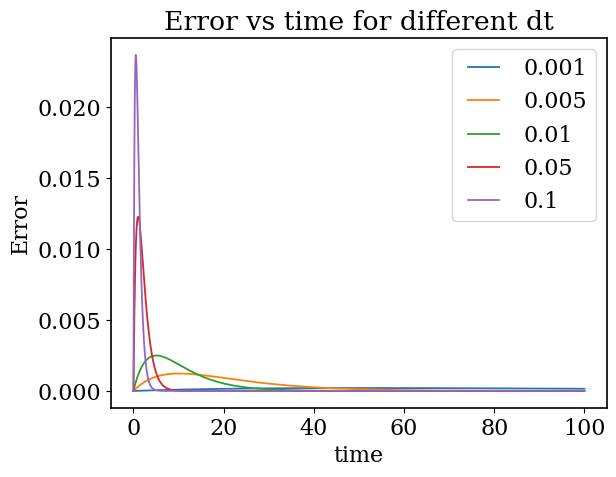

In [42]:
for n in range(len(dt)):
    plt.plot(times, err_array[n], label= dt[n])

plt.legend()
plt.title("Error vs time for different dt")
plt.ylabel("Error")
plt.xlabel("time")

## Maximum error vs Time step

Since we use implicit euler method, we expect the error to go linearly with time-step.

Text(0.5, 1.0, 'Maximum Error vs dt')

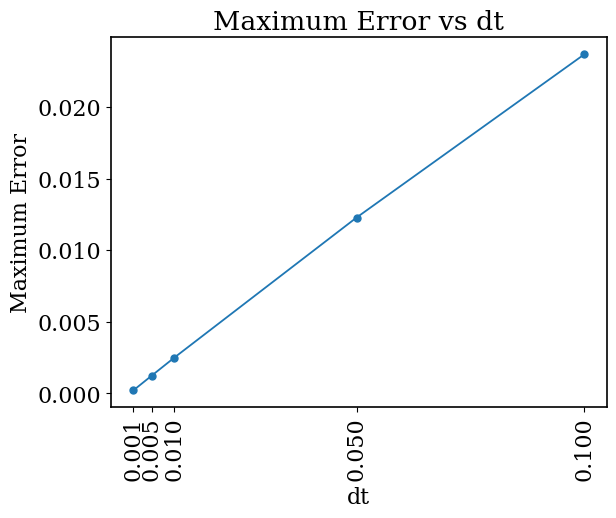

In [43]:
plt.plot(dt, np.max(err_array, axis = 1), marker="o")
plt.xticks(dt, rotation= 90)
plt.ylabel("Maximum Error")
plt.xlabel("dt")
plt.title("Maximum Error vs dt")

## Error calculation for domain divition changes

In [44]:
nx = np.array([8,16,24,48,64])
L=1
D,k,c0,n,a= 0.2,0,0,1,1
dt = 0.001, 0.005, 0.01, 0.05, 0.1
nt = 1000
tmax = dt*nt
n=1

#error

err_array = np.zeros((len(nx), nt))
uarray = np.zeros((len(nx), nt, len(u_0.x.array)))


for indx,nxx in enumerate(nx):
    domain= mesh.create_unit_interval(MPI.COMM_WORLD, nx[indx])
    
    # Function Space
    V = dfx.fem.functionspace(domain, ('P', 1))
    u_0 = fem.Function(V)
    u_t = dfx.fem.Function(V)
    tu = ufl.TestFunction(V)
    u_0.x.array[:] = np.zeros(len(u_0.x.array))
    u_t.x.array[:] = np.zeros(len(u_t.x.array))
    
    uarray = np.zeros((len(nx), nt, len(u_0.x.array)))
    
    times = np.linspace(0, tmax, nt)
    u_0.interpolate(lambda x: np.cos(np.pi*x[0])+c0)
   
    uarray[indx, 0] =  u_0.x.array
    #print(u_t.x.array)
    form = (ufl.dot((u_t -u_0)/dtt, tu) +  D*ufl.inner(ufl.grad(u_t),ufl.grad(tu))+ k*ufl.dot(u_t-c0,tu))*ufl.dx



    
    V2 = fem.functionspace(domain, ("Lagrange", 1)) 
    uex = fem.Function(V2)
    uex.interpolate(lambda x: np.cos(np.pi*x[0])*np.exp(-D*0*dtt*np.pi**2))
    L2_error = fem.form(ufl.inner( u_0 - uex, u_0- uex) * ufl.dx)
    error_local = fem.assemble_scalar(L2_error)
    error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
    err_array[indx, 0] = error_L2

    problem = NonlinearProblem(form, u_t, bcs=[])
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    for tt in range(1, nt):
        solver.solve(u_t)
        u_0.x.array[:] = u_t.x.array
        uarray[indx, tt] = u_0.x.array
        uex.interpolate(lambda x:c0+ a*np.cos(np.pi*x[0])*np.exp((-D*n**2+k)*tt*dt[indx]*np.pi**2))
        L2_error = fem.form(ufl.inner( u_0 - uex, u_0- uex) * ufl.dx)
        error_local = fem.assemble_scalar(L2_error)
        error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
        err_array[indx, tt] = error_L2
        
    

## Maximum error vs Time step

Since we use implicit euler method, we expect the error to go linearly with time-step.

Text(0.5, 1.0, 'Maximum Error vs no of sub domains')

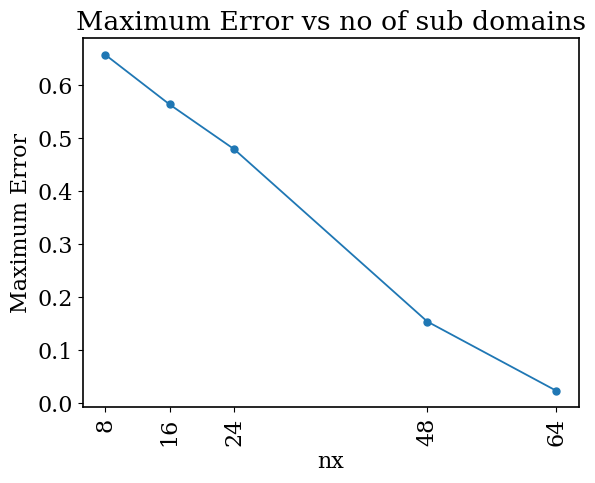

In [45]:
plt.plot(nx, np.max(err_array, axis = 1), marker="o")
plt.xticks(nx, rotation= 90)
plt.ylabel("Maximum Error")
plt.xlabel("nx")
plt.title("Maximum Error vs no of sub domains")